# Import Libraries

In [1]:
import os

import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
tqdm.pandas()

C:\Users\Alu\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Util

In [3]:
def get_cat_2(x):
    l = x['categories'].replace('[','').replace(']','').split('|')
    if len(l)>2:
        return l[2]
    return ''

In [4]:
def create_o_vectors(x):
    vec = [0]*len(map_aspects)
    for i in range (len(x)):
        vec[map_aspects[x.iloc[i]['key_aspect']]] = x.iloc[i]['predicted_score']
    
    return pd.Series(vec+[x['scores'].values[0]])

# Import and format data

In [5]:
df_proba = pd.read_csv('Weights Cell Phones & Accessories.csv')
map_aspects = {x[1]['key_aspect']:x[1]['index'] for x in df_proba.reset_index().iterrows()}

In [6]:
# this is basicaly the output of the Sentiment analyzer (I just imported the parquet and change it to csv)
df_reg = pd.read_csv('Cell_Phones_Accessories.csv').drop(['Unnamed: 0', 'idx_', 'asin', 'prediction', 'main_cat', 'reviews', 'split_aspect', 'count', 'text'], axis=1)
df_reg.head()

,idx,categories,scores,key_aspect,predicted_score
0,51539801461,Cell Phones & Accessories|Accessories|Headsets...,4.0,good,0.978743
1,833223815502,Cell Phones & Accessories|Accessories|Screen P...,5.0,good|one|put|part|quality,0.999654
2,412316932342,Cell Phones & Accessories|Cases|Basic Cases|El...,5.0,amazing,0.999928
3,1236950607268,Cell Phones & Accessories|Accessories|Accessor...,5.0,easy,0.991919
4,1700807108971,Cell Phones & Accessories|Cases|Basic Cases|,1.0,hard,-0.730210


In [7]:
# create two level of categories
df_reg['cat_1'] = df_reg.progress_apply(lambda x : x['categories'].replace('[','').replace(']','').split('|')[1], axis=1)
df_reg['cat_2'] = df_reg.progress_apply(lambda x : get_cat_2(x), axis=1)

100%|█████████████████████████████████████████████████████████████████████| 1297964/1297964 [00:24<00:00, 52307.74it/s]


In [22]:
df_reg.head()

,idx,categories,scores,key_aspect,predicted_score,cat_1,cat_2
0,51539801461,Cell Phones & Accessories|Accessories|Headsets...,4.0,good,0.978743,Accessories,Headsets
1,833223815502,Cell Phones & Accessories|Accessories|Screen P...,5.0,good|one|put|part|quality,0.999654,Accessories,Screen Protectors
2,412316932342,Cell Phones & Accessories|Cases|Basic Cases|El...,5.0,amazing,0.999928,Cases,Basic Cases
3,1236950607268,Cell Phones & Accessories|Accessories|Accessor...,5.0,easy,0.991919,Accessories,Accessory Kits
4,1700807108971,Cell Phones & Accessories|Cases|Basic Cases|,1.0,hard,-0.730210,Cases,Basic Cases


# Category Overview

### Category level 1 

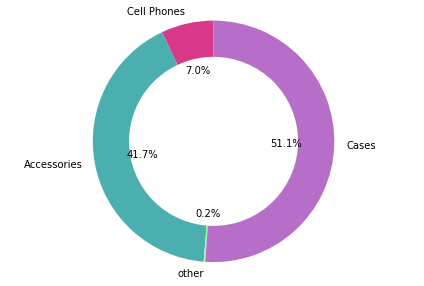

In [8]:
labels = ['Cell Phones', 'Accessories', 'other', 'Cases']
sizes = [34471, 204632, 215+877, 250894]

colors = ['#D83988','#4CAFAF','#99ff99','#B76EC8']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


ax1.axis('equal')  
plt.tight_layout()
plt.show()

### level 2 Category (inside Accessories)

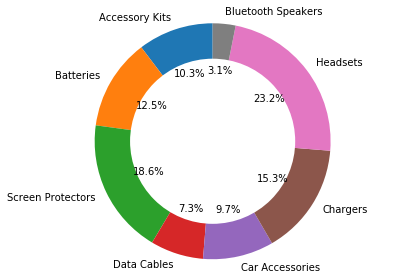

In [9]:
labels = ['Accessory Kits', 'Batteries', 'Screen Protectors', 'Data Cables', 'Car Accessories', 'Chargers', 'Headsets', 'Bluetooth Speakers']
sizes = [17993, 21763, 32338, 12657, 16884, 26657, 40290, 5449]

# colors = ['#D83988','#4CAFAF','#99ff99','#B76EC8']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


ax1.axis('equal')  
plt.tight_layout()
plt.show()

# Global Category Aspect Visualization

In [10]:
aspects_list = ['cheap', 'battery|life|95%', 'larger', 'different', 'compatible', 'solid', 'design']
category = 'global'

### Frequencies

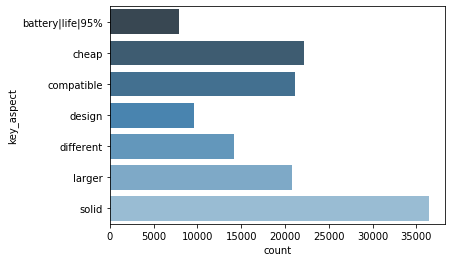

In [49]:
ax = sns.barplot(x="count", 
                 y="key_aspect", 
                 data=df_proba[df_proba['key_aspect'].isin(aspects_list)].sort_values('key_aspect'),
          palette="Blues_d")

### Proba weights

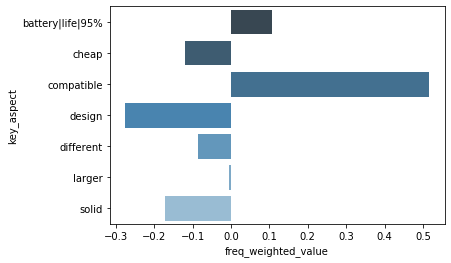

In [53]:
ax = sns.barplot(x="freq_weighted_value", 
                 y="key_aspect", 
                 data=df_proba[df_proba['key_aspect'].isin(aspects_list)].sort_values('key_aspect'),
          palette="Blues_d")

### Linear reg importance values

In [13]:
if "W_reg_"+category+".npy" in os.listdir('.'):
    W_reg = np.load("W_reg_"+category+".npy")
else :
    # takes around 15 minutes
    df_train = df_reg.groupby('idx').progress_apply(create_o_vectors)
    X = df_train.iloc[:,:-1].values
    y = df_train.iloc[:,-1].values
    mod = sm.OLS(y, X)
    res = mod.fit()

    coefs = res.params
    stds = res.bse  
    W_reg = np.array([[np.random.normal(loc=coefs[i], scale=stds[i]) for i in range(X.shape[1])]    for j in range(min(X.shape[0], 5000)) ])
    np.save("W_reg_"+category+".npy", W_reg)

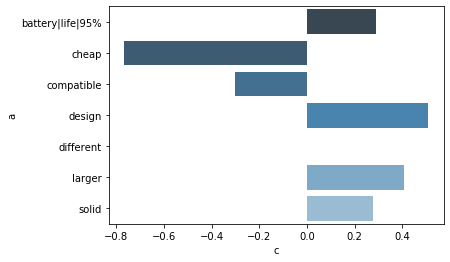

In [51]:
df_boxchart = pd.DataFrame(W_reg, columns = df_proba['key_aspect'].values)
df_boxchart = df_boxchart[aspects_list]
df_boxchart = pd.melt(df_boxchart, var_name="a", value_name="c")

ax = sns.barplot(x="c", 
                 y="a", 
                 data=df_boxchart.groupby('a').mean().reset_index().sort_values('a'),
                 palette="Blues_d"
                )

# Sub-Category Aspect Visualization

## Cell Phones sub-category

In [68]:
category = "Batteries"
level = "2"

### Frequencies

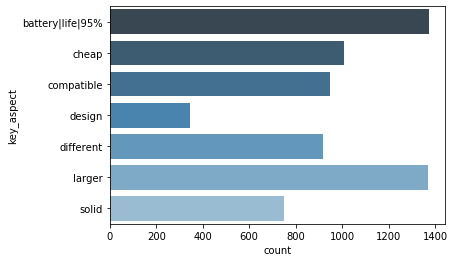

In [69]:
data_chart = df_reg.copy()
data_chart['count'] = 1
data_chart = data_chart[data_chart['cat_'+level]==category]
data_chart = data_chart[data_chart['key_aspect'].isin(aspects_list)]
data_chart = data_chart.groupby('key_aspect').count().reset_index().sort_values("key_aspect")
ax = sns.barplot(x="count", 
                 y="key_aspect", 
                 data=data_chart,
          palette="Blues_d")

### Linear reg importance values

In [70]:
if "W_reg_"+category+".npy" in os.listdir('.'):
    W_reg = np.load("W_reg_"+category+".npy")
else :
    df_reg_cat = df_reg[df_reg['cat_'+level]==category]
    df_train = df_reg_cat.groupby('idx').progress_apply(create_o_vectors)
    X = df_train.iloc[:,:-1].values
    y = df_train.iloc[:,-1].values
    mod = sm.OLS(y, X)
    res = mod.fit()

    coefs = res.params
    stds = res.bse
    W_reg = np.array([[np.random.normal(loc=coefs[i], scale=stds[i]) for i in range(X.shape[1])]    for j in range(X.shape[0]) ])
    np.save("W_reg_"+category+".npy", W_reg)

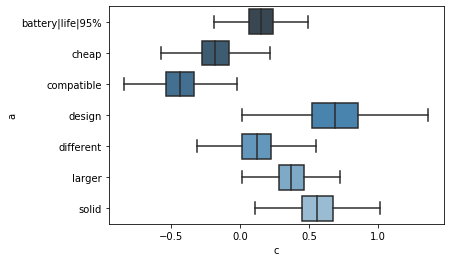

In [71]:
df_boxchart = pd.DataFrame(W_reg, columns = df_proba['key_aspect'].values)
df_boxchart = df_boxchart[aspects_list]
df_boxchart = pd.melt(df_boxchart, var_name="a", value_name="c").sort_values('a')
ax = sns.boxplot(x="c", y="a", data=df_boxchart, palette="Blues_d",
                showfliers=False)

## Case sub-category

In [72]:
category = "Cases"
level = "1"

### Frequencies

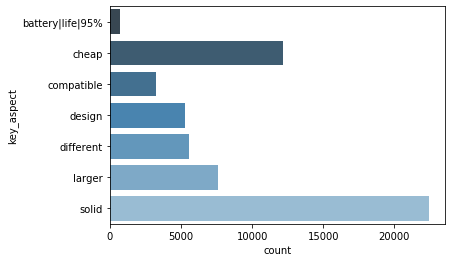

In [73]:
data_chart = df_reg.copy()
data_chart['count'] = 1
data_chart = data_chart[data_chart['cat_'+level]==category]
data_chart = data_chart[data_chart['key_aspect'].isin(aspects_list)]
data_chart = data_chart.groupby('key_aspect').count().reset_index().sort_values("key_aspect")
ax = sns.barplot(x="count", 
                 y="key_aspect", 
                 data=data_chart,
          palette="Blues_d")

### Linear reg importance values

In [74]:
if "W_reg_"+category+".npy" in os.listdir('.'):
    W_reg = np.load("W_reg_"+category+".npy")
else :
    df_reg_cat = df_reg[df_reg['cat_'+level]==category]
    df_train = df_reg_cat.groupby('idx').progress_apply(create_o_vectors)
    X = df_train.iloc[:,:-1].values
    y = df_train.iloc[:,-1].values
    mod = sm.OLS(y, X)
    res = mod.fit()

    coefs = res.params
    stds = res.bse
    W_reg = np.array([[np.random.normal(loc=coefs[i], scale=stds[i]) for i in range(X.shape[1])]    for j in range(X.shape[0]) ])
    np.save("W_reg_"+category+".npy", W_reg)

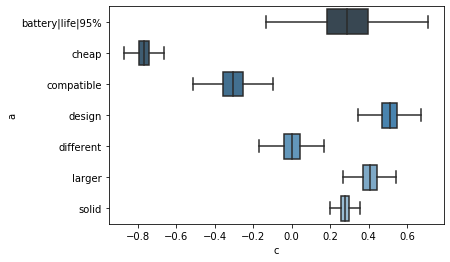

In [75]:
df_boxchart = pd.DataFrame(W_reg, columns = df_proba['key_aspect'].values)
df_boxchart = df_boxchart[aspects_list]
df_boxchart = pd.melt(df_boxchart, var_name="a", value_name="c").sort_values('a')
ax = sns.boxplot(x="c", y="a", data=df_boxchart, palette="Blues_d",
                showfliers=False)